#### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn import GCNConv, GATConv, ChebConv,GATv2Conv, SAGEConv,global_max_pool
from torch_geometric.nn import knn_graph
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from scipy.stats import gaussian_kde
from torch_geometric.utils import dense_to_sparse
from tqdm import tqdm

# Modeling

In [2]:
class ImageEncoder(nn.Module):
    """
    Maps an input image [B, in_channels, H, W] down to [B, feature_dim, H/4, W/4]
    using two (Conv -> BN -> ReLU -> MaxPool) blocks.
    """
    def __init__(self, in_channels=3, feature_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Downsamples H->H/2, W->W/2
            
            # Block 2
            nn.Conv2d(32, feature_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # Downsamples H->H/4, W->W/4
        )
    
    def forward(self, x):
        """
        x: [B, in_channels, H, W]
        returns: [B, feature_dim, H/4, W/4]
        """
        return self.encoder(x)

class ImageDecoder(nn.Module):
    """
    Maps a feature map [B, feature_dim, H/4, W/4] back up to
    [B, out_channels, H, W] using two (Upsample -> Conv -> BN -> ReLU) blocks.
    """
    def __init__(self, feature_dim=64, out_channels=3):
        super().__init__()
        self.decoder = nn.Sequential(
            # Block 1
            nn.Upsample(scale_factor=2, mode='nearest'),  # H/4 -> H/2
            nn.Conv2d(feature_dim, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Block 2
            nn.Upsample(scale_factor=2, mode='nearest'),  # H/2 -> H
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            # Optional: BatchNorm on the final out_channels if desired
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)  # Or remove/replace with Sigmoid if it's an AE for e.g. grayscale [0,1]
        )
    
    def forward(self, x):
        """
        x: [B, feature_dim, H/4, W/4]
        returns: [B, out_channels, H, W]
        """
        return self.decoder(x)


class PairwiseMLP(nn.Module):
    """
    Given two node vectors (dim=node_dim), produce a scalar similarity score.
    score_ij = MLP([x_i || x_j]).
    """
    def __init__(self, node_dim, hidden_dim=64):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2 * node_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)  # scalar output
        )
    
    def forward(self, node_i, node_j):
        # node_i, node_j: [B, node_dim] each (or [1, node_dim] if processing one pair at a time)
        x = torch.cat([node_i, node_j], dim=-1)  # [B, 2*node_dim]
        score = self.mlp(x)  # [B, 1]
        return score


# --------------------------
# 4. GCN Encoder/Decoder (PyG)
# --------------------------
class GCNEncoder(nn.Module):
    """
    Encodes node features into latent embeddings using GCN layers.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        # Hidden layers (if more than 2)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # Last layer
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_channels, out_channels))
        else:
            self.convs[0] = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        """
        x: [N, in_channels]
        edge_index: [2, E]
        edge_weight: [E] or None
        """
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
        return x


class GCNDecoder(nn.Module):
    """
    Decodes latent embeddings back to e.g. original node dimension.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super().__init__()
        self.num_layers = num_layers
        self.convs = nn.ModuleList()

        # First layer
        self.convs.append(GCNConv(in_channels, hidden_channels))
        # Hidden layers (if more than 2)
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        # Last layer
        if num_layers > 1:
            self.convs.append(GCNConv(hidden_channels, out_channels))
        else:
            self.convs[0] = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_weight)
            if i < self.num_layers - 1:
                x = F.relu(x)
        return x


# ----------------------------
# 5. Full Autoencoder Pipeline
# ----------------------------
class ImageGraphAutoencoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        feature_dim=64,   # output of CNN encoder
        node_dim=64,      # dimension for node embeddings
        encoder_hidden=64,
        decoder_hidden=64,
        gcn_encoder_layers=2,
        gcn_decoder_layers=2
    ):
        """
        - in_channels: # of channels in the input image
        - feature_dim: # of feature maps from ImageEncoder
        - node_dim: dimension for node embeddings
        - encoder_hidden, decoder_hidden: hidden dims for GCN layers
        - gcn_encoder_layers, gcn_decoder_layers: number of GCNConv layers for encoder/decoder
        """
        super().__init__()
        
        # 1) CNN Encoder
        self.image_encoder = ImageEncoder(in_channels, feature_dim)
        
        # 2) MLP for pairwise adjacency
        self.pairwise_mlp = PairwiseMLP(node_dim)
        
        # 3) GCN encoder
        self.gcn_encoder = GCNEncoder(
            in_channels=node_dim,
            hidden_channels=encoder_hidden,
            out_channels=encoder_hidden,  # or some chosen latent size
            num_layers=gcn_encoder_layers
        )
        
        # 4) GCN decoder
        self.gcn_decoder = GCNDecoder(
            in_channels=encoder_hidden,
            hidden_channels=decoder_hidden,
            out_channels=node_dim,  # decode back to node_dim
            num_layers=gcn_decoder_layers
        )
        
        # 5) CNN Decoder
        self.image_decoder = ImageDecoder(feature_dim=feature_dim, out_channels=in_channels)
    
    def forward(self, x):
        """
        x: [B, in_channels, H, W]
        returns: reconstructed image [B, in_channels, H, W]
        """
        B, C, H, W = x.shape
        # -----------------------
        # Encoder part
        # -----------------------
        # 1) CNN Encoder -> feature maps
        feat_maps = self.image_encoder(x)  # [B, feature_dim, H/4, W/4]
        # 2) Flatten to get nodes
        B, Fm, Hf, Wf = feat_maps.shape
        N = Hf * Wf
        nodes_batch = feat_maps.view(B, Fm, N).permute(0, 2, 1).contiguous()  # [B, N, F]

        recon_list = []
        for b_idx in range(B):
            # isolate one example in the batch
            node_features = nodes_batch[b_idx]  # [N, F]
            N_b = node_features.shape[0]
            
            # ------------------------------------
            # Build adjacency via Pairwise MLP
            # (Naive all-pairs approach)
            # ------------------------------------
            A_dense = torch.zeros(N_b, N_b, device=x.device)
            
            for i in range(N_b):
                for j in range(N_b):
                    score = self.pairwise_mlp(
                        node_features[i, :],
                        node_features[j, :]
                    )  # shape [1,1]
                    A_dense[i, j] = score
            
            # normalize row-wise
            A_dense = F.softmax(A_dense, dim=-1)  # [N_b, N_b]
            
            # convert to sparse format for PyG
            edge_index, edge_attr = dense_to_sparse(A_dense)
            
            # ------------------------------------
            # GCN Encoder
            # ------------------------------------
            latent_nodes = self.gcn_encoder(node_features, edge_index, edge_attr)  # [N_b, encoder_hidden]
            
            # ----------------------
            # Decoder part
            # ----------------------
            # 1) GCN Decoder
            decoded_nodes = self.gcn_decoder(latent_nodes, edge_index, edge_attr)  # [N_b, node_dim]
            
            # 2) Reshape nodes -> feature maps
            decoded_maps = decoded_nodes.view(Fm, Hf, Wf).unsqueeze(0)  # [1, F, Hf, Wf]
            
            # 3) CNN Decoder -> reconstruct image
            recon_image = self.image_decoder(decoded_maps)  # [1, C, H, W]
            recon_list.append(recon_image)
        
        # Combine along batch dimension
        recon_x = torch.cat(recon_list, dim=0)  # [B, C, H, W]
        
        return recon_x


# Data Reading and Preprocessing

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to [0,1] tensor [C,H,W]
])

data_root = './data'

# 2. Download EMNIST 'letters' dataset for TRAIN
emnist_train_dataset = datasets.EMNIST(
    root=data_root, split='letters',
    train=True, transform=transform, download=True
)

# 3. Convert train dataset to a numpy array (only the image part)
X_data = []
for img_tensor, _ in emnist_train_dataset:
    # `img_tensor` shape: [1, 28, 28]
    # If you want to transpose or reshape, you can do so here,
    # but usually for an autoencoder, it's fine to keep as [1, 28, 28].
    X_data.append(img_tensor.numpy())

X_data = np.array(X_data)  # shape: [N, 1, 28, 28]

# 4. Split into train/val
X_train, X_val = train_test_split(X_data, test_size=0.1, random_state=42)

# 5. Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)  # [N_train, 1, 28, 28]
X_val   = torch.FloatTensor(X_val)    # [N_val, 1, 28, 28]

print("Train set shape:", X_train.shape)
print("Val set shape:  ", X_val.shape)

Train set shape: torch.Size([112320, 1, 28, 28])
Val set shape:   torch.Size([12480, 1, 28, 28])


In [4]:
batch_size = 64

# For an autoencoder, inputs == targets
train_dataset = TensorDataset(X_train, X_train)  # (data, same data)
val_dataset   = TensorDataset(X_val,   X_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)

# 6. Prepare the TEST set
emnist_test_dataset = datasets.EMNIST(
    root=data_root, split='letters',
    train=False, transform=transform, download=True
)

# Convert test dataset to numpy array
X_test_data = []
for img_tensor, _ in emnist_test_dataset:
    X_test_data.append(img_tensor.numpy())

X_test_data = np.array(X_test_data)
X_test = torch.FloatTensor(X_test_data)

test_dataset = TensorDataset(X_test, X_test)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Test set shape: ", X_test.shape)

Test set shape:  torch.Size([20800, 1, 28, 28])


In [5]:
def plot_images(X, Y, title):
    """
    Plots pairs of images: X[i] on the top row, Y[i] on the bottom row.
    For an autoencoder, X[i] and Y[i] are the same unless you modify them.
    """
    plt.figure(figsize=(15, 5))
    for i in range(5):
        # Plot X images
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i].squeeze(), cmap='gray')
        plt.title(f"{title} X: {i}", fontsize=12)
        plt.axis('off')
        
        # Plot Y images (should be identical if autoencoder input=target)
        plt.subplot(2, 5, i + 6)
        plt.imshow(Y[i].squeeze(), cmap='gray')
        plt.title(f"{title} Y: {i}", fontsize=12)
        plt.axis('off')
    plt.show()

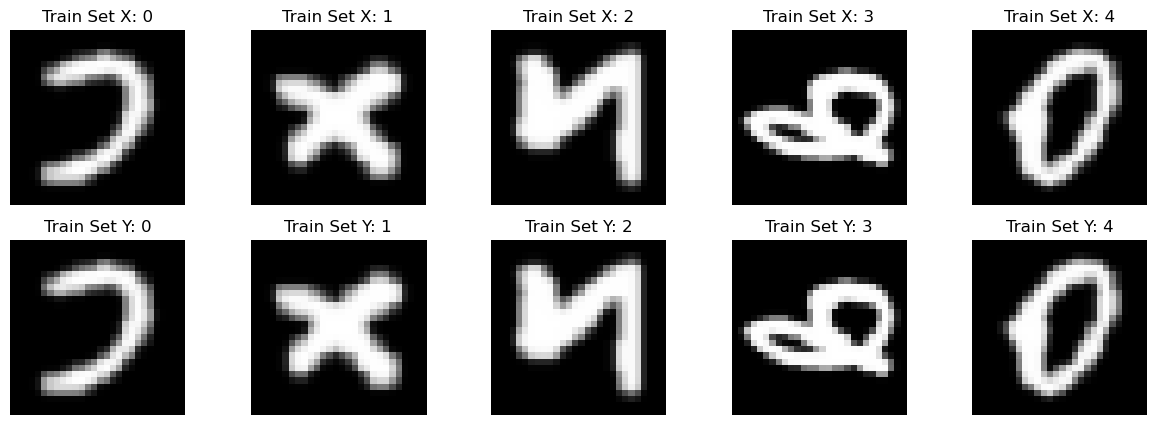

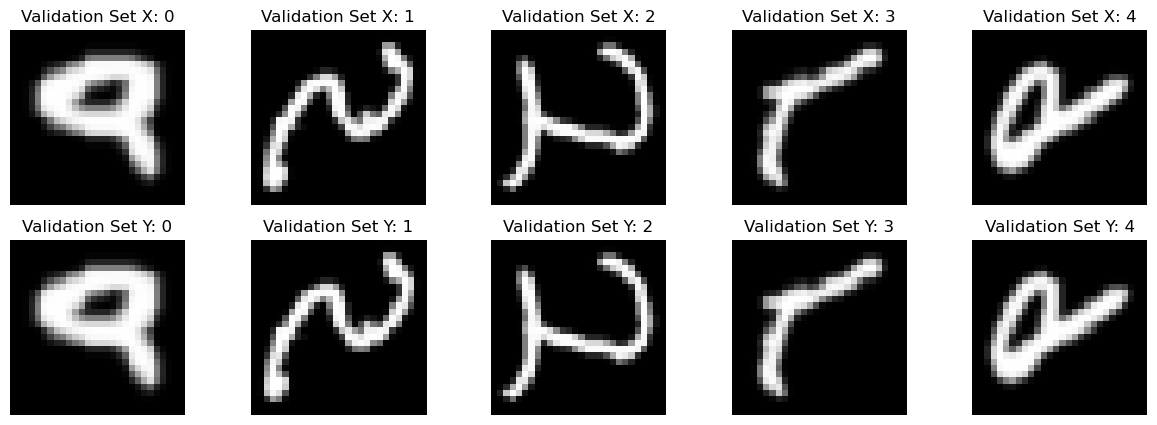

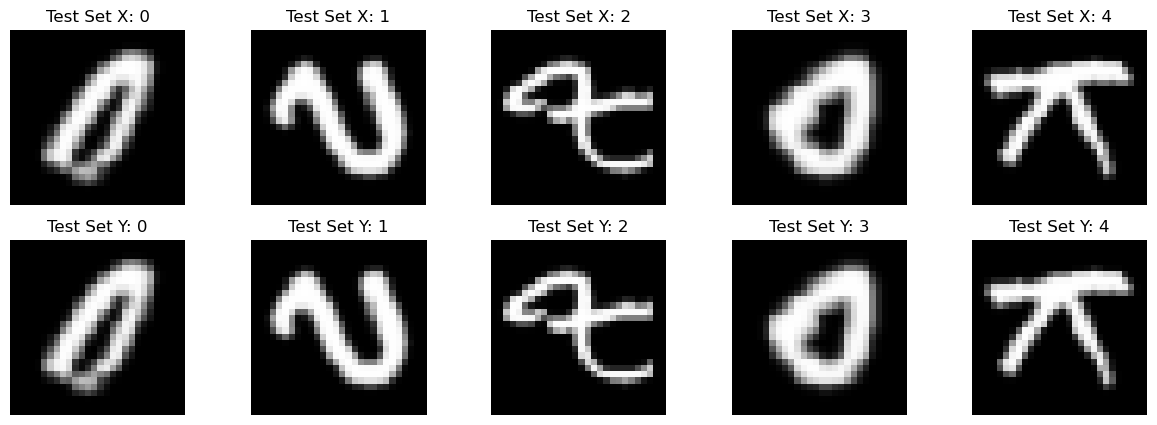

In [6]:
np.random.seed(42)  # for reproducibility

num_samples = 10
train_samples_indices = np.random.choice(len(X_train), num_samples, replace=False)
val_samples_indices   = np.random.choice(len(X_val),   num_samples, replace=False)
test_samples_indices  = np.random.choice(len(X_test),  num_samples, replace=False)

train_samples = X_train[train_samples_indices]
val_samples   = X_val[val_samples_indices]
test_samples  = X_test[test_samples_indices]

# For an autoencoder, input=target, so Y is the same
plot_images(train_samples, train_samples, "Train Set")
plot_images(val_samples,   val_samples,   "Validation Set")
plot_images(test_samples,  test_samples,  "Test Set")

# Model Training and Validation

In [ ]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImageGraphAutoencoder(
    in_channels=1,
    feature_dim=32,
    node_dim=32,
    encoder_hidden=16,
    decoder_hidden=16,
    gcn_encoder_layers=1,
    gcn_decoder_layers=1
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_losses = []
epochs = 20
best_val_loss = float('inf')


for epoch in range(epochs):
    # -------------------------
    # Training
    # -------------------------
    model.train()
    epoch_train_loss = 0.0
    
    # Wrap train_loader with tqdm for a progress bar
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
    for batch in train_pbar:
        batch_inputs = batch[0].to(device)  # (inputs, targets) but here targets == inputs for autoencoder
        
        optimizer.zero_grad()
        reconstructed = model(batch_inputs)
        
        loss = criterion(reconstructed, batch_inputs)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
        # Optionally update tqdm bar with current loss
        train_pbar.set_postfix({"train_loss": loss.item()})
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # -------------------------
    # Validation
    # -------------------------
    model.eval()
    epoch_val_loss = 0.0
    
    # Wrap val_loader with tqdm for a progress bar
    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_pbar:
            batch_inputs = batch[0].to(device)
            reconstructed = model(batch_inputs)
            
            loss = criterion(reconstructed, batch_inputs)
            epoch_val_loss += loss.item()
            
            # Optionally update tqdm bar with current val loss
            val_pbar.set_postfix({"val_loss": loss.item()})
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Model saved with validation loss: {avg_val_loss:.4f}")
    
    
    # -------------------------
    # Logging
    # -------------------------
    print(f"Epoch [{epoch+1}/{epochs}] - "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}")

Epoch 1/20 [Train]:   0%|          | 2/439 [02:23<9:00:27, 74.20s/it, train_loss=0.132]